In [1973]:
import os
import requests
from bs4 import BeautifulSoup
import textwrap
import pandas as pd
import lxml  
import time
from IPython.display import clear_output
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from time import sleep
import re
from tqdm import tqdm
from functools import reduce

In [1974]:
data = pd.read_csv('processed_data.csv')
data

,average_rating,price,reviews_num,max_cpu_frequency,cpu_architecture,web_camera,weight,ethernet_adapter,pixel_response_time,microphone,...,li_ion_battery_type,ultrabook,touch_numeric_keypad,cpu_scores,dedicated_gpu_scores,integrated_gpu_scores,AdobeRGB,DCI-P3,NTSC,sRGB
0,4.2,24999.0,17.0,2.8,Goldmont Plus,True,1.05,False,NaN,True,...,True,False,False,1618,0.0,333.0,NaN,NaN,45.0,NaN
1,4.7,24999.0,3.0,2.8,Goldmont Plus,True,1.05,False,NaN,True,...,False,False,False,1618,0.0,333.0,NaN,NaN,45.0,NaN
2,4.6,24999.0,9.0,2.8,Goldmont Plus,True,1.05,False,NaN,True,...,True,False,False,1618,0.0,333.0,NaN,NaN,45.0,NaN
3,3.8,28999.0,9.0,2.6,Excavator,True,2.00,False,NaN,True,...,True,False,False,1249,0.0,307.0,NaN,NaN,NaN,NaN
4,NaN,28999.0,NaN,2.2,Excavator,True,1.94,True,NaN,True,...,True,False,False,908,0.0,307.0,NaN,NaN,45.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
723,NaN,313999.0,NaN,4.5,Comet Lake,True,2.10,True,NaN,True,...,True,False,False,11346,13971.0,1163.0,100.0,NaN,NaN,NaN
724,3.0,349999.0,2.0,4.5,Comet Lake,True,2.10,True,NaN,True,...,True,False,False,11346,16706.0,1163.0,100.0,NaN,NaN,NaN
725,NaN,379999.0,NaN,5.0,Comet Lake,True,2.54,True,NaN,True,...,True,False,False,12627,13889.0,1163.0,100.0,NaN,NaN,NaN
726,NaN,380999.0,NaN,4.5,Comet Lake,True,2.10,True,NaN,True,...,True,False,False,11346,16706.0,1163.0,100.0,NaN,NaN,NaN


In [1975]:
data.dtypes[data.dtypes == object]

cpu_architecture            object
cpu_family                  object
screen_resolution_name      object
os                          object
gpu_manufacturer            object
cpu_manufacturer            object
graphics_ram_type           object
ram_type                    object
display_type                object
adaptive_sync_technology    object
brand_name                  object
dtype: object

In [1976]:
data = data.drop(['reviews_num', 'average_rating'], axis = 1)

# data.drop(data.index[data.average_rating.isnull()], inplace = True)

In [1977]:
def print_whole_df(df):
    with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
        print(df)

In [1978]:
# every object column will be One-Hot-Encoded

In [1979]:
groups = []

prev_row = None

group = []

for idx, row in data.iterrows():
    if idx == 0 or (row.brand_name == prev_row.brand_name):
        group.append(idx)
    else:
        groups.append(group)
        group = [idx]
        
    prev_row = row
    
groups = pd.Series(groups)
groups

0                   [0, 1, 2, 3]
1                            [4]
2                            [5]
3                         [6, 7]
4             [8, 9, 10, 11, 12]
                 ...            
465                   [709, 710]
466              [711, 712, 713]
467                   [714, 715]
468    [716, 717, 718, 719, 720]
469                        [721]
Length: 470, dtype: object

In [1980]:
from sklearn.model_selection import train_test_split

def custom_train_test_split(data, groups, test_size = 0.3):
    ratio = len(data) / len(groups)
    
    train_groups, test_groups = train_test_split(groups, test_size = test_size * ratio)
    
    train_idxs = list(reduce(lambda el1, el2: el1 + el2, [group for group in train_groups]))
    
    test_idxs = [pd.Series(group).sample().values[0] for group in test_groups]
    
    print(train_idxs[:10])
    print(test_idxs[:10])
    
    train, test = data.loc[train_idxs], data.loc[test_idxs]
    
    return train, test

In [1981]:
train, test = custom_train_test_split(data = data, groups = groups)

[376, 377, 573, 507, 508, 8, 9, 10, 11, 12]
[667, 708, 698, 640, 678, 164, 223, 653, 408, 76]


In [1982]:
# train, test = data.iloc[:len(data) - 5, :], data.iloc[len(data) - 5:, :]

In [1983]:
len(data), len(train), len(test)

(728, 385, 219)

In [1984]:
X_train, y_train = train.drop('price', axis = 1), train.price
X_test, y_test = test.drop('price', axis = 1), test.price

# train = train.drop(['price', 'average_rating'], axis = 1)
# test = test.drop(['price', 'average_rating'], axis = 1)
# X_train, y_train = train.drop('reviews_num', axis = 1), train.reviews_num
# X_test, y_test = test.drop('reviews_num', axis = 1), test.reviews_num

In [1985]:
def col_info(col_name = None):
    print(f'col_name = {col_name}')
    print(f'col_dtype = {data[col_name].dtype}\n')
    print('unique_values_counts:\n')
    print(data[col_name].value_counts(dropna = False))

In [1986]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse = False, handle_unknown = 'ignore')

def one_hot_encode_col(train_df, test_df, col):
    
    new_train = pd.DataFrame(ohe.fit_transform(train_df[col].values.reshape(-1, 1))).set_index(train_df.index)
    new_train.columns = [col + f'_{i}' for i in range(new_train.shape[1])]
    
    new_test = pd.DataFrame(ohe.transform(test_df[col].values.reshape(-1, 1))).set_index(test_df.index)
    new_test.columns = [col + f'_{i}' for i in range(new_test.shape[1])]
    
    return pd.concat([new_train, train_df.drop(col, axis = 1)], axis = 1), \
           pd.concat([new_test, test_df.drop(col, axis = 1)], axis = 1)

In [1987]:
# from sklearn.preprocessing import OneHotEncoder

# ohe = OneHotEncoder(sparse = False, handle_unknown = 'ignore')

# def one_hot_encode_col(train_df, test_df, col):
    
#     print(col)
    
#     print(test_df.cpu_family.isnull().any())
    
#     new_train = pd.DataFrame(ohe.fit_transform(train_df[col].values.reshape(-1, 1)))
#     new_train.columns = [col + f'_{i}' for i in range(new_train.shape[1])]
    
#     print(test_df.cpu_family.isnull().any())
    
#     new_test = pd.DataFrame(ohe.transform(test_df[col].values.reshape(-1, 1)))
#     new_test.columns = [col + f'_{i}' for i in range(new_test.shape[1])]
    
#     print(test_df.cpu_family.isnull().any())
    
#     print(new_test.columns)
#     print(test_df.columns)
    
#     return new_test.set_index(test_df.index), test_df.drop(col, axis = 1)

# df_new, df_test = one_hot_encode_col(X_train, X_test, 'cpu_architecture')


In [1988]:
col_info('cpu_architecture')

col_name = cpu_architecture
col_dtype = object

unique_values_counts:

Comet Lake       236
Zen 2            124
Ice Lake         123
Coffee Lake       63
Willow Cove       51
Zen               34
Zen+              31
Goldmont Plus     24
Whiskey Lake      14
Excavator         10
Tiger Lake         8
NaN                5
Amber Lake-Y       2
GoldMont           1
Broadwell          1
Kaby Lake          1
Name: cpu_architecture, dtype: int64


In [1989]:
data.cpu_architecture.mode()

0    Comet Lake
dtype: object

In [1990]:
X_train['cpu_architecture'] = X_train.cpu_architecture.fillna(X_train.cpu_architecture.mode().values[0])
X_test['cpu_architecture'] = X_test.cpu_architecture.fillna(X_test.cpu_architecture.mode().values[0])
one_hot_encode_col(X_train, X_test, 'cpu_architecture')
X_train, X_test = one_hot_encode_col(X_train, X_test, 'cpu_architecture')
X_train.columns.values, X_test.columns.values

(array(['cpu_architecture_0', 'cpu_architecture_1', 'cpu_architecture_2',
        'cpu_architecture_3', 'cpu_architecture_4', 'cpu_architecture_5',
        'cpu_architecture_6', 'cpu_architecture_7', 'cpu_architecture_8',
        'cpu_architecture_9', 'cpu_architecture_10', 'cpu_architecture_11',
        'cpu_architecture_12', 'max_cpu_frequency', 'web_camera', 'weight',
        'ethernet_adapter', 'pixel_response_time', 'microphone',
        'warranty_duration', 'depth', 'screen_diagonal',
        'battery_capacity', 'gaming_laptop', 'kensington_lock',
        'cpu_cores_num', 'l2_cache', 'l3_cache', 'cpu_family',
        'screen_refresh_rate', 'threads_num', 'max_possible_ram',
        'screen_resolution_name', 'hdd_capacity', 'ssd_capacity',
        'graphics_ram', 'intel_optane_drive_capacity', 'os',
        'optical_disc_drive', 'ppi', 'usb_power_delivery',
        'keyboard_backlight', 'usb_2_0_ports', 'usb_3_x_ports',
        'usb_type_c_ports', 'estimated_battery_life', 'gpu_ma

In [1991]:
col_info('cpu_family')

col_name = cpu_family
col_dtype = object

unique_values_counts:

Core i7    225
Core i5    199
Ryzen 5     76
Ryzen 7     56
Core i3     46
Pentium     40
Ryzen 3     37
Athlon      14
Core i9     10
Celeron      7
Ryzen 9      6
A4           5
A9           3
A6           2
M1           2
Name: cpu_family, dtype: int64


In [1992]:
X_train, X_test = one_hot_encode_col(X_train, X_test, 'cpu_family')
X_train.columns, X_test.columns

(Index(['cpu_family_0', 'cpu_family_1', 'cpu_family_2', 'cpu_family_3',
        'cpu_family_4', 'cpu_family_5', 'cpu_family_6', 'cpu_family_7',
        'cpu_family_8', 'cpu_family_9',
        ...
        'li_ion_battery_type', 'ultrabook', 'touch_numeric_keypad',
        'cpu_scores', 'dedicated_gpu_scores', 'integrated_gpu_scores',
        'AdobeRGB', 'DCI-P3', 'NTSC', 'sRGB'],
       dtype='object', length=129),
 Index(['cpu_family_0', 'cpu_family_1', 'cpu_family_2', 'cpu_family_3',
        'cpu_family_4', 'cpu_family_5', 'cpu_family_6', 'cpu_family_7',
        'cpu_family_8', 'cpu_family_9',
        ...
        'li_ion_battery_type', 'ultrabook', 'touch_numeric_keypad',
        'cpu_scores', 'dedicated_gpu_scores', 'integrated_gpu_scores',
        'AdobeRGB', 'DCI-P3', 'NTSC', 'sRGB'],
       dtype='object', length=129))

In [1993]:
col_info('screen_resolution_name')

col_name = screen_resolution_name
col_dtype = object

unique_values_counts:

FullHD    639
UHD        38
HD+        18
HD         15
WQXGA      10
QHD         5
WXGA+       1
WQHD        1
WQXGA+      1
Name: screen_resolution_name, dtype: int64


In [1994]:
X_train, X_test = one_hot_encode_col(X_train, X_test, 'screen_resolution_name')
X_train.columns, X_test.columns

(Index(['screen_resolution_name_0', 'screen_resolution_name_1',
        'screen_resolution_name_2', 'screen_resolution_name_3',
        'screen_resolution_name_4', 'screen_resolution_name_5',
        'screen_resolution_name_6', 'cpu_family_0', 'cpu_family_1',
        'cpu_family_2',
        ...
        'li_ion_battery_type', 'ultrabook', 'touch_numeric_keypad',
        'cpu_scores', 'dedicated_gpu_scores', 'integrated_gpu_scores',
        'AdobeRGB', 'DCI-P3', 'NTSC', 'sRGB'],
       dtype='object', length=135),
 Index(['screen_resolution_name_0', 'screen_resolution_name_1',
        'screen_resolution_name_2', 'screen_resolution_name_3',
        'screen_resolution_name_4', 'screen_resolution_name_5',
        'screen_resolution_name_6', 'cpu_family_0', 'cpu_family_1',
        'cpu_family_2',
        ...
        'li_ion_battery_type', 'ultrabook', 'touch_numeric_keypad',
        'cpu_scores', 'dedicated_gpu_scores', 'integrated_gpu_scores',
        'AdobeRGB', 'DCI-P3', 'NTSC', 'sRGB'],


In [1995]:
col_info('os')

col_name = os
col_dtype = object

unique_values_counts:

Windows 10 Home            426
DOS                        115
UNIX-подобная               90
Windows 10 Professional     74
macOS                       12
Windows 10 S                11
Name: os, dtype: int64


In [1996]:
X_train, X_test = one_hot_encode_col(X_train, X_test, 'os')
X_train.columns, X_test.columns

(Index(['os_0', 'os_1', 'os_2', 'os_3', 'os_4', 'os_5',
        'screen_resolution_name_0', 'screen_resolution_name_1',
        'screen_resolution_name_2', 'screen_resolution_name_3',
        ...
        'li_ion_battery_type', 'ultrabook', 'touch_numeric_keypad',
        'cpu_scores', 'dedicated_gpu_scores', 'integrated_gpu_scores',
        'AdobeRGB', 'DCI-P3', 'NTSC', 'sRGB'],
       dtype='object', length=140),
 Index(['os_0', 'os_1', 'os_2', 'os_3', 'os_4', 'os_5',
        'screen_resolution_name_0', 'screen_resolution_name_1',
        'screen_resolution_name_2', 'screen_resolution_name_3',
        ...
        'li_ion_battery_type', 'ultrabook', 'touch_numeric_keypad',
        'cpu_scores', 'dedicated_gpu_scores', 'integrated_gpu_scores',
        'AdobeRGB', 'DCI-P3', 'NTSC', 'sRGB'],
       dtype='object', length=140))

In [1997]:
col_info('gpu_manufacturer')

col_name = gpu_manufacturer
col_dtype = object

unique_values_counts:

nVidia    329
Intel     250
AMD       147
Apple       2
Name: gpu_manufacturer, dtype: int64


In [1998]:
X_train, X_test = one_hot_encode_col(X_train, X_test, 'gpu_manufacturer')
X_train.columns, X_test.columns

(Index(['gpu_manufacturer_0', 'gpu_manufacturer_1', 'gpu_manufacturer_2',
        'os_0', 'os_1', 'os_2', 'os_3', 'os_4', 'os_5',
        'screen_resolution_name_0',
        ...
        'li_ion_battery_type', 'ultrabook', 'touch_numeric_keypad',
        'cpu_scores', 'dedicated_gpu_scores', 'integrated_gpu_scores',
        'AdobeRGB', 'DCI-P3', 'NTSC', 'sRGB'],
       dtype='object', length=142),
 Index(['gpu_manufacturer_0', 'gpu_manufacturer_1', 'gpu_manufacturer_2',
        'os_0', 'os_1', 'os_2', 'os_3', 'os_4', 'os_5',
        'screen_resolution_name_0',
        ...
        'li_ion_battery_type', 'ultrabook', 'touch_numeric_keypad',
        'cpu_scores', 'dedicated_gpu_scores', 'integrated_gpu_scores',
        'AdobeRGB', 'DCI-P3', 'NTSC', 'sRGB'],
       dtype='object', length=142))

In [1999]:
col_info('cpu_manufacturer')

col_name = cpu_manufacturer
col_dtype = object

unique_values_counts:

Intel    527
AMD      199
Apple      2
Name: cpu_manufacturer, dtype: int64


In [2000]:
X_train, X_test = one_hot_encode_col(X_train, X_test, 'cpu_manufacturer')
X_train.columns, X_test.columns

(Index(['cpu_manufacturer_0', 'cpu_manufacturer_1', 'gpu_manufacturer_0',
        'gpu_manufacturer_1', 'gpu_manufacturer_2', 'os_0', 'os_1', 'os_2',
        'os_3', 'os_4',
        ...
        'li_ion_battery_type', 'ultrabook', 'touch_numeric_keypad',
        'cpu_scores', 'dedicated_gpu_scores', 'integrated_gpu_scores',
        'AdobeRGB', 'DCI-P3', 'NTSC', 'sRGB'],
       dtype='object', length=143),
 Index(['cpu_manufacturer_0', 'cpu_manufacturer_1', 'gpu_manufacturer_0',
        'gpu_manufacturer_1', 'gpu_manufacturer_2', 'os_0', 'os_1', 'os_2',
        'os_3', 'os_4',
        ...
        'li_ion_battery_type', 'ultrabook', 'touch_numeric_keypad',
        'cpu_scores', 'dedicated_gpu_scores', 'integrated_gpu_scores',
        'AdobeRGB', 'DCI-P3', 'NTSC', 'sRGB'],
       dtype='object', length=143))

In [2001]:
col_info('graphics_ram_type')

col_name = graphics_ram_type
col_dtype = object

unique_values_counts:

SMA      366
GDDR6    261
GDDR5     97
NaN        4
Name: graphics_ram_type, dtype: int64


In [2002]:
X_train['graphics_ram_type'] = X_train.graphics_ram_type.fillna(X_train.graphics_ram_type.mode().values[0])
X_test['graphics_ram_type'] = X_test.graphics_ram_type.fillna(X_test.graphics_ram_type.mode().values[0])
X_train, X_test = one_hot_encode_col(X_train, X_test, 'graphics_ram_type')
X_train.columns, X_test.columns

(Index(['graphics_ram_type_0', 'graphics_ram_type_1', 'graphics_ram_type_2',
        'cpu_manufacturer_0', 'cpu_manufacturer_1', 'gpu_manufacturer_0',
        'gpu_manufacturer_1', 'gpu_manufacturer_2', 'os_0', 'os_1',
        ...
        'li_ion_battery_type', 'ultrabook', 'touch_numeric_keypad',
        'cpu_scores', 'dedicated_gpu_scores', 'integrated_gpu_scores',
        'AdobeRGB', 'DCI-P3', 'NTSC', 'sRGB'],
       dtype='object', length=145),
 Index(['graphics_ram_type_0', 'graphics_ram_type_1', 'graphics_ram_type_2',
        'cpu_manufacturer_0', 'cpu_manufacturer_1', 'gpu_manufacturer_0',
        'gpu_manufacturer_1', 'gpu_manufacturer_2', 'os_0', 'os_1',
        ...
        'li_ion_battery_type', 'ultrabook', 'touch_numeric_keypad',
        'cpu_scores', 'dedicated_gpu_scores', 'integrated_gpu_scores',
        'AdobeRGB', 'DCI-P3', 'NTSC', 'sRGB'],
       dtype='object', length=145))

In [2003]:
col_info('ram_type')

col_name = ram_type
col_dtype = object

unique_values_counts:

DDR4       632
LPDDR4x     58
LPDDR3      25
LPDDR4      12
DDR3L        1
Name: ram_type, dtype: int64


In [2004]:
X_train, X_test = one_hot_encode_col(X_train, X_test, 'ram_type')
X_train.columns, X_test.columns

(Index(['ram_type_0', 'ram_type_1', 'ram_type_2', 'ram_type_3', 'ram_type_4',
        'graphics_ram_type_0', 'graphics_ram_type_1', 'graphics_ram_type_2',
        'cpu_manufacturer_0', 'cpu_manufacturer_1',
        ...
        'li_ion_battery_type', 'ultrabook', 'touch_numeric_keypad',
        'cpu_scores', 'dedicated_gpu_scores', 'integrated_gpu_scores',
        'AdobeRGB', 'DCI-P3', 'NTSC', 'sRGB'],
       dtype='object', length=149),
 Index(['ram_type_0', 'ram_type_1', 'ram_type_2', 'ram_type_3', 'ram_type_4',
        'graphics_ram_type_0', 'graphics_ram_type_1', 'graphics_ram_type_2',
        'cpu_manufacturer_0', 'cpu_manufacturer_1',
        ...
        'li_ion_battery_type', 'ultrabook', 'touch_numeric_keypad',
        'cpu_scores', 'dedicated_gpu_scores', 'integrated_gpu_scores',
        'AdobeRGB', 'DCI-P3', 'NTSC', 'sRGB'],
       dtype='object', length=149))

In [2005]:
X_train, X_test = one_hot_encode_col(X_train, X_test, 'display_type')
X_train.columns, X_test.columns

(Index(['display_type_0', 'display_type_1', 'display_type_2', 'display_type_3',
        'display_type_4', 'ram_type_0', 'ram_type_1', 'ram_type_2',
        'ram_type_3', 'ram_type_4',
        ...
        'li_ion_battery_type', 'ultrabook', 'touch_numeric_keypad',
        'cpu_scores', 'dedicated_gpu_scores', 'integrated_gpu_scores',
        'AdobeRGB', 'DCI-P3', 'NTSC', 'sRGB'],
       dtype='object', length=153),
 Index(['display_type_0', 'display_type_1', 'display_type_2', 'display_type_3',
        'display_type_4', 'ram_type_0', 'ram_type_1', 'ram_type_2',
        'ram_type_3', 'ram_type_4',
        ...
        'li_ion_battery_type', 'ultrabook', 'touch_numeric_keypad',
        'cpu_scores', 'dedicated_gpu_scores', 'integrated_gpu_scores',
        'AdobeRGB', 'DCI-P3', 'NTSC', 'sRGB'],
       dtype='object', length=153))

In [2006]:
col_info('adaptive_sync_technology')

col_name = adaptive_sync_technology
col_dtype = object

unique_values_counts:

нет              559
NVIDIA G-SYNC     67
NaN               67
Adaptive-Sync     29
AMD FreeSync       6
Name: adaptive_sync_technology, dtype: int64


In [2007]:
X_train['adaptive_sync_technology'] = X_train.adaptive_sync_technology.fillna(X_train.adaptive_sync_technology.mode().values[0])
X_test['adaptive_sync_technology'] = X_test.adaptive_sync_technology.fillna(X_test.adaptive_sync_technology.mode().values[0])
X_train, X_test = one_hot_encode_col(X_train, X_test, 'adaptive_sync_technology')
X_train.columns, X_test.columns

(Index(['adaptive_sync_technology_0', 'adaptive_sync_technology_1',
        'adaptive_sync_technology_2', 'adaptive_sync_technology_3',
        'display_type_0', 'display_type_1', 'display_type_2', 'display_type_3',
        'display_type_4', 'ram_type_0',
        ...
        'li_ion_battery_type', 'ultrabook', 'touch_numeric_keypad',
        'cpu_scores', 'dedicated_gpu_scores', 'integrated_gpu_scores',
        'AdobeRGB', 'DCI-P3', 'NTSC', 'sRGB'],
       dtype='object', length=156),
 Index(['adaptive_sync_technology_0', 'adaptive_sync_technology_1',
        'adaptive_sync_technology_2', 'adaptive_sync_technology_3',
        'display_type_0', 'display_type_1', 'display_type_2', 'display_type_3',
        'display_type_4', 'ram_type_0',
        ...
        'li_ion_battery_type', 'ultrabook', 'touch_numeric_keypad',
        'cpu_scores', 'dedicated_gpu_scores', 'integrated_gpu_scores',
        'AdobeRGB', 'DCI-P3', 'NTSC', 'sRGB'],
       dtype='object', length=156))

In [2008]:
X_train, X_test = one_hot_encode_col(X_train, X_test, 'brand_name')
X_train.columns, X_test.columns

(Index(['brand_name_0', 'brand_name_1', 'brand_name_2', 'brand_name_3',
        'brand_name_4', 'brand_name_5', 'brand_name_6', 'brand_name_7',
        'brand_name_8', 'adaptive_sync_technology_0',
        ...
        'li_ion_battery_type', 'ultrabook', 'touch_numeric_keypad',
        'cpu_scores', 'dedicated_gpu_scores', 'integrated_gpu_scores',
        'AdobeRGB', 'DCI-P3', 'NTSC', 'sRGB'],
       dtype='object', length=164),
 Index(['brand_name_0', 'brand_name_1', 'brand_name_2', 'brand_name_3',
        'brand_name_4', 'brand_name_5', 'brand_name_6', 'brand_name_7',
        'brand_name_8', 'adaptive_sync_technology_0',
        ...
        'li_ion_battery_type', 'ultrabook', 'touch_numeric_keypad',
        'cpu_scores', 'dedicated_gpu_scores', 'integrated_gpu_scores',
        'AdobeRGB', 'DCI-P3', 'NTSC', 'sRGB'],
       dtype='object', length=164))

In [2009]:
X_train.dtypes[X_train.dtypes == object], X_test.dtypes[X_test.dtypes == object]

(Series([], dtype: object), Series([], dtype: object))

In [2010]:
### filling nan's

In [2011]:
data.columns[(data.dtypes != object) & data.isnull().any()]

Index(['max_cpu_frequency', 'weight', 'pixel_response_time', 'depth',
       'battery_capacity', 'l2_cache', 'l3_cache', 'screen_refresh_rate',
       'threads_num', 'intel_optane_drive_capacity', 'usb_power_delivery',
       'keyboard_backlight', 'estimated_battery_life', 'M_2_connector',
       'cpu_lithography', 'cpu_frequency', 'ram_frequency', 'width',
       'release_year', 'memory_slots_num', 'glossy_display',
       'integrated_gpu_scores', 'AdobeRGB', 'DCI-P3', 'NTSC', 'sRGB'],
      dtype='object')

In [2012]:
col_info('max_cpu_frequency')

col_name = max_cpu_frequency
col_dtype = float64

unique_values_counts:

4.2    91
4.5    85
5.0    71
3.7    60
4.0    58
4.1    54
3.6    41
3.4    36
3.9    32
4.8    30
4.7    27
5.1    24
3.5    21
NaN    21
3.1    15
4.9    11
3.2     9
2.8     5
5.3     5
4.4     5
3.3     5
2.7     5
2.2     3
2.6     3
3.8     3
2.9     2
4.6     2
3.0     2
4.3     1
2.4     1
Name: max_cpu_frequency, dtype: int64


In [2013]:
col = 'max_cpu_frequency'
X_train[col] = X_train[col].fillna(X_train[col].mean())
X_test[col] = X_test[col].fillna(X_test[col].mean())

In [2014]:
col_info('weight')

col_name = weight
col_dtype = float64

unique_values_counts:

1.900    57
2.300    47
1.800    46
2.200    34
2.600    26
         ..
1.005     1
1.470     1
1.790     1
1.210     1
1.150     1
Name: weight, Length: 91, dtype: int64


In [2015]:
data.weight.isnull().sum()

11

In [2016]:
col = 'weight'
X_train[col] = X_train[col].fillna(X_train[col].mean())
X_test[col] = X_test[col].fillna(X_test[col].mean())

In [2017]:
col_info('pixel_response_time')

col_name = pixel_response_time
col_dtype = float64

unique_values_counts:

NaN    690
3.0     32
7.0      6
Name: pixel_response_time, dtype: int64


In [2018]:
X_train.drop('pixel_response_time', axis = 1, inplace = True, errors = 'ignore')
X_test.drop('pixel_response_time', axis = 1, inplace = True, errors = 'ignore')

In [2019]:
col_info('depth')

col_name = depth
col_dtype = float64

unique_values_counts:

255.0    42
250.5    31
228.0    28
233.8    23
208.0    23
         ..
225.0     1
240.0     1
204.5     1
263.0     1
226.4     1
Name: depth, Length: 121, dtype: int64


In [2020]:
data.depth.isnull().sum()

1

In [2021]:
col = 'depth'
X_train[col] = X_train[col].fillna(X_train[col].mean())
X_test[col] = X_test[col].fillna(X_test[col].mean())

In [2022]:
col_info('battery_capacity')

col_name = battery_capacity
col_dtype = float64

unique_values_counts:

NaN            175
3693.693694     34
4684.684685     28
5045.045045     26
4343.000000     23
              ... 
5171.171171      1
4955.000000      1
5063.063063      1
8108.108108      1
3333.333333      1
Name: battery_capacity, Length: 95, dtype: int64


In [2023]:
col = 'battery_capacity'
X_train[col + '_is_missing'] = X_train[col].isnull()
X_train[col] = X_train[col].fillna(X_train[col].mean())
X_test[col + '_is_missing'] = X_test[col].isnull()
X_test[col] = X_test[col].fillna(X_test[col].mean())

In [2024]:
col_info('l2_cache')

col_name = l2_cache
col_dtype = float64

unique_values_counts:

1.0    249
2.0    163
1.5    104
4.0     81
3.0     52
5.0     51
0.5     17
2.5      7
NaN      4
Name: l2_cache, dtype: int64


In [2025]:
col = 'l2_cache'
X_train[col] = X_train[col].fillna(X_train[col].mode().values[0])
X_test[col] = X_test[col].fillna(X_test[col].mode().values[0])

In [2026]:
col_info('l3_cache')

col_name = l3_cache
col_dtype = float64

unique_values_counts:

8.0     267
12.0    135
4.0     126
6.0     103
16.0     36
0.0      35
2.0      19
NaN       4
3.0       2
9.0       1
Name: l3_cache, dtype: int64


In [2027]:
col = 'l3_cache'
X_train[col] = X_train[col].fillna(X_train[col].mode().values[0])
X_test[col] = X_test[col].fillna(X_test[col].mode().values[0])

In [2028]:
col_info('screen_refresh_rate')

col_name = screen_refresh_rate
col_dtype = float64

unique_values_counts:

60.0     545
144.0     94
120.0     48
NaN       15
300.0     13
240.0     13
Name: screen_refresh_rate, dtype: int64


In [2029]:
col = 'screen_refresh_rate'
X_train[col] = X_train[col].fillna(X_train[col].mode().values[0])
X_test[col] = X_test[col].fillna(X_test[col].mode().values[0])

In [2030]:
col_info('threads_num')

col_name = threads_num
col_dtype = float64

unique_values_counts:

8.0     335
4.0     131
12.0    127
16.0     79
6.0      29
2.0      26
NaN       1
Name: threads_num, dtype: int64


In [2031]:
col = 'threads_num'
X_train[col] = X_train[col].fillna(X_train[col].mode().values[0])
X_test[col] = X_test[col].fillna(X_test[col].mode().values[0])

In [2032]:
col_info('intel_optane_drive_capacity')

col_name = intel_optane_drive_capacity
col_dtype = float64

unique_values_counts:

0.0     722
NaN       5
32.0      1
Name: intel_optane_drive_capacity, dtype: int64


In [2033]:
X_train.drop('intel_optane_drive_capacity', axis = 1, inplace = True, errors = 'ignore')
X_test.drop('intel_optane_drive_capacity', axis = 1, inplace = True, errors = 'ignore')

In [2034]:
col_info('usb_power_delivery')

col_name = usb_power_delivery
col_dtype = float64

unique_values_counts:

0.0    361
1.0    197
NaN    170
Name: usb_power_delivery, dtype: int64


In [2035]:
col = 'usb_power_delivery'
X_train[col + '_is_missing'] = X_train[col].isnull()
X_train[col] = X_train[col].fillna(X_train[col].mode().values[0])
X_test[col + '_is_missing'] = X_test[col].isnull()
X_test[col] = X_test[col].fillna(X_test[col].mode().values[0])

In [2036]:
col_info('keyboard_backlight')

col_name = keyboard_backlight
col_dtype = float64

unique_values_counts:

1.0    562
0.0    150
NaN      8
0.5      8
Name: keyboard_backlight, dtype: int64


In [2037]:
col = 'keyboard_backlight'
X_train[col] = X_train[col].fillna(X_train[col].mode().values[0])
X_test[col] = X_test[col].fillna(X_test[col].mode().values[0])

In [2038]:
col_info('estimated_battery_life')

col_name = estimated_battery_life
col_dtype = float64

unique_values_counts:

NaN     176
8.0      96
7.0      63
10.0     55
6.0      50
12.0     42
11.0     35
5.0      35
4.0      34
9.0      31
14.0     26
3.0      22
11.5     11
15.0      8
16.0      7
10.5      5
24.0      5
17.0      4
22.0      4
13.0      3
13.5      3
18.0      3
17.5      2
20.0      2
19.3      2
4.5       1
15.9      1
3.5       1
2.5       1
Name: estimated_battery_life, dtype: int64


In [2039]:
col = 'estimated_battery_life'
X_train[col + '_is_missing'] = X_train[col].isnull()
X_train[col] = X_train[col].fillna(X_train[col].mean())
X_test[col + '_is_missing'] = X_test[col].isnull()
X_test[col] = X_test[col].fillna(X_test[col].mean())

In [2040]:
col_info('M_2_connector')

col_name = M_2_connector
col_dtype = float64

unique_values_counts:

1.0    700
0.0     21
NaN      7
Name: M_2_connector, dtype: int64


In [2041]:
col = 'M_2_connector'
X_train[col] = X_train[col].fillna(X_train[col].mode().values[0])
X_test[col] = X_test[col].fillna(X_test[col].mode().values[0])

In [2042]:
col_info('cpu_lithography')

col_name = cpu_lithography
col_dtype = float64

unique_values_counts:

14.0    379
10.0    180
7.0     124
12.0     30
28.0     10
NaN       3
5.0       2
Name: cpu_lithography, dtype: int64


In [2043]:
col = 'cpu_lithography'
X_train[col] = X_train[col].fillna(X_train[col].mode().values[0])
X_test[col] = X_test[col].fillna(X_test[col].mode().values[0])

In [2044]:
col_info('cpu_frequency')

col_name = cpu_frequency
col_dtype = float64

unique_values_counts:

2.6    124
2.3     85
2.4     67
2.5     53
1.0     41
2.1     39
1.8     37
1.1     37
1.6     36
1.2     35
2.9     31
1.3     29
3.0     27
2.0     25
2.8     24
2.7     17
1.5      5
3.3      5
3.1      3
1.7      3
NaN      2
2.2      2
1.4      1
Name: cpu_frequency, dtype: int64


In [2045]:
col = 'cpu_frequency'
X_train[col] = X_train[col].fillna(X_train[col].mean())
X_test[col] = X_test[col].fillna(X_test[col].mean())

In [2046]:
col_info('ram_frequency')

col_name = ram_frequency
col_dtype = float64

unique_values_counts:

2666.0    197
3200.0    177
2933.0    109
2400.0     92
2133.0     73
NaN        49
3733.0     14
1866.0     10
4266.0      4
1600.0      3
Name: ram_frequency, dtype: int64


In [2047]:
col = 'ram_frequency'
X_train[col + '_is_missing'] = X_train[col].isnull()
X_train[col] = X_train[col].fillna(X_train[col].mean())
X_test[col + '_is_missing'] = X_test[col].isnull()
X_test[col] = X_test[col].fillna(X_test[col].mean())

In [2048]:
col_info('width')

col_name = width
col_dtype = float64

unique_values_counts:

363.4    87
360.0    46
358.5    37
359.0    30
324.0    26
         ..
399.7     1
311.5     1
311.0     1
284.4     1
359.9     1
Name: width, Length: 101, dtype: int64


In [2049]:
data.width.isnull().sum()

1

In [2050]:
col = 'width'
X_train[col] = X_train[col].fillna(X_train[col].mean())
X_test[col] = X_test[col].fillna(X_test[col].mean())

In [2051]:
col_info('release_year')

col_name = release_year
col_dtype = float64

unique_values_counts:

2020.0    652
2019.0     65
NaN         7
2017.0      2
2018.0      2
Name: release_year, dtype: int64


In [2052]:
col = 'release_year'
X_train[col] = X_train[col].fillna(X_train[col].mode().values[0])
X_test[col] = X_test[col].fillna(X_test[col].mode().values[0])

In [2053]:
col_info('memory_slots_num')

col_name = memory_slots_num
col_dtype = float64

unique_values_counts:

2.0    315
0.0    193
1.0    167
NaN     48
4.0      5
Name: memory_slots_num, dtype: int64


In [2054]:
col = 'memory_slots_num'
X_train[col + '_is_missing'] = X_train[col].isnull()
X_train[col] = X_train[col].fillna(X_train[col].mode().values[0])
X_test[col + '_is_missing'] = X_test[col].isnull()
X_test[col] = X_test[col].fillna(X_test[col].mode().values[0])

In [2055]:
col_info('glossy_display')

col_name = glossy_display
col_dtype = float64

unique_values_counts:

0.0    629
1.0     86
NaN     13
Name: glossy_display, dtype: int64


In [2056]:
col = 'glossy_display'
X_train[col] = X_train[col].fillna(X_train[col].mode().values[0])
X_test[col] = X_test[col].fillna(X_test[col].mode().values[0])

In [2057]:
col_info('integrated_gpu_scores')

col_name = integrated_gpu_scores
col_dtype = float64

unique_values_counts:

1163.0     208
1920.0     111
920.0       59
2918.0      54
1255.0      48
1878.0      47
3730.0      47
1578.0      34
897.0       26
366.0       20
2790.0      17
NaN         14
460.0        8
1524.0       6
333.0        6
307.0        6
667.0        5
407.0        3
339.0        2
767.0        2
842.0        2
14189.0      2
1789.0       1
Name: integrated_gpu_scores, dtype: int64


In [2058]:
col = 'integrated_gpu_scores'
X_train[col] = X_train[col].fillna(X_train[col].mean())
X_test[col] = X_test[col].fillna(X_test[col].mean())

In [2059]:
col_info('AdobeRGB')

col_name = AdobeRGB
col_dtype = float64

unique_values_counts:

NaN      614
100.0     29
50.0      21
39.0      10
48.0       9
37.0       5
36.0       5
47.0       5
77.0       5
60.0       5
63.0       5
59.0       3
41.0       3
67.0       3
65.0       2
58.0       2
38.0       1
64.0       1
Name: AdobeRGB, dtype: int64


In [2060]:
X_train.drop('AdobeRGB', axis = 1, inplace = True, errors = 'ignore')
X_test.drop('AdobeRGB', axis = 1, inplace = True, errors = 'ignore')

In [2061]:
col_info('DCI-P3')

col_name = DCI-P3
col_dtype = float64

unique_values_counts:

NaN      721
100.0      5
90.0       2
Name: DCI-P3, dtype: int64


In [2062]:
X_train.drop('DCI-P3', axis = 1, inplace = True, errors = 'ignore')
X_test.drop('DCI-P3', axis = 1, inplace = True, errors = 'ignore')

In [2063]:
col_info('NTSC')

col_name = NTSC
col_dtype = float64

unique_values_counts:

NaN     443
45.0    220
72.0     49
60.0      7
46.0      5
70.0      4
Name: NTSC, dtype: int64


In [2064]:
col = 'NTSC'
X_train[col + '_is_missing'] = X_train[col].isnull()
X_train[col] = X_train[col].fillna(X_train[col].mode().values[0])
X_test[col + '_is_missing'] = X_test[col].isnull()
# X_test[col] = X_test[col].fillna(X_test[col].mode().values[0])
X_test[col] = X_test[col].fillna(0)

In [2065]:
X_test[col]

667    72.0
708     0.0
698     0.0
640     0.0
678     0.0
       ... 
370    45.0
89     45.0
522     0.0
309    46.0
568    72.0
Name: NTSC, Length: 219, dtype: float64

In [2066]:
col_info('sRGB')

col_name = sRGB
col_dtype = float64

unique_values_counts:

NaN      490
100.0    130
62.0      27
67.0      19
54.0      13
58.0       5
65.0       5
85.0       5
57.0       5
94.0       5
64.0       4
92.0       4
59.0       3
56.0       3
91.0       3
99.0       2
95.0       1
80.0       1
98.0       1
60.0       1
89.0       1
Name: sRGB, dtype: int64


In [2067]:
col = 'sRGB'
X_train[col + '_is_missing'] = X_train[col].isnull()
X_train[col] = X_train[col].fillna(X_train[col].mode().values[0])
X_test[col + '_is_missing'] = X_test[col].isnull()
# X_test[col] = X_test[col].fillna(X_test[col].mode().values[0])
X_test[col] = X_test[col].fillna(0)

In [2068]:
X_train.columns[X_train.isnull().any()], X_test.columns[X_test.isnull().any()]

(Index([], dtype='object'), Index([], dtype='object'))

In [1471]:
########

In [1472]:
from sklearn.ensemble import RandomForestRegressor

In [1473]:
# index_to_drop = X_train.average_rating.isnull()
# X_train.drop(X_train.index[index_to_drop], inplace = True)
# y_train.drop(y_train.index[index_to_drop], inplace = True)
# index_to_drop = X_test.average_rating.isnull()
# X_test.drop(X_test.index[index_to_drop], inplace = True)
# y_test.drop(y_test.index[index_to_drop], inplace = True)

In [1474]:
reg = RandomForestRegressor(n_estimators=1000, n_jobs = -1).fit(X_train, y_train)
reg.score(X_test, y_test)

0.8794164753961831

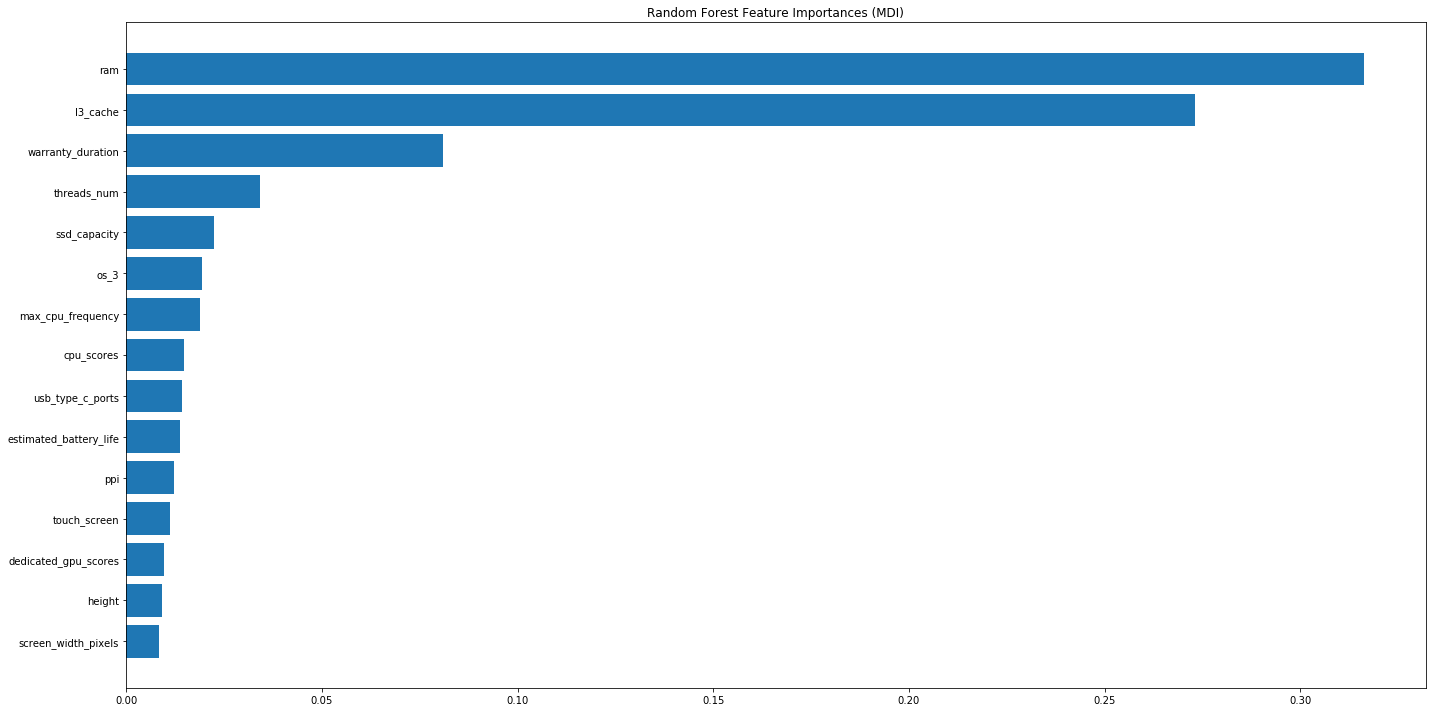

In [1475]:
def get_feature_importances(random_forest_model, keep_first = 15):
    tree_feature_importances = random_forest_model.feature_importances_
    
    sorted_idx = tree_feature_importances.argsort()

    y_ticks = np.arange(0, keep_first)
    fig, ax = plt.subplots(figsize = (20, 10))
    ax.barh(y_ticks, tree_feature_importances[sorted_idx][-keep_first:])
    ax.set_yticklabels(X_test.columns[sorted_idx][-keep_first:])
    ax.set_yticks(y_ticks)
    ax.set_title("Random Forest Feature Importances (MDI)")
    fig.tight_layout()
    plt.show()
    
get_feature_importances(reg)

In [1476]:
preds = reg.predict(X_test)

In [1477]:
y_test

164     51999.0
448     87999.0
182     52999.0
676    180999.0
217     59999.0
         ...   
88      41999.0
84      40999.0
184     53999.0
535     99999.0
141     48999.0
Name: price, Length: 219, dtype: float64

In [1478]:
res = pd.concat([pd.Series(reg.predict(X_test), index = y_test.index, name = 'Predict'), \
                 pd.Series(y_test, name = "Price")], axis = 1).sort_index()
print_whole_df(res.head(20))

         Predict    Price
0   34901.400000  24999.0
4   31341.000000  28999.0
13  35574.000000  32999.0
14  42152.933333  32999.0
21  35385.400000  34999.0
25  37186.133333  34999.0
29  38381.000000  34999.0
31  36948.000000  35999.0
49  44566.833333  36999.0
53  37560.400000  37999.0
57  44828.666667  37999.0
58  38749.500000  37999.0
61  43671.000000  38499.0
62  35769.400000  38999.0
63  42583.500000  38999.0
68  46035.000000  39999.0
72  44039.000000  39999.0
74  36821.000000  39999.0
77  47071.066667  39999.0
81  41232.000000  39999.0


In [1479]:
(res.Predict - res.Price).abs().describe()

count      219.000000
mean     10646.015119
std      12982.054709
min          0.950000
25%       3021.775000
50%       6046.222143
75%      12936.900000
max      94739.200000
dtype: float64

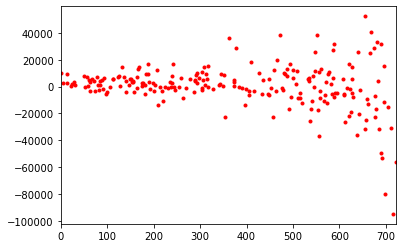

In [1480]:
(res.Predict - res.Price).plot(style = 'r.')

In [1481]:
res.apply(lambda vals: vals['Predict'] - vals['Price'], axis = 1).abs().describe()

count      219.000000
mean     10646.015119
std      12982.054709
min          0.950000
25%       3021.775000
50%       6046.222143
75%      12936.900000
max      94739.200000
dtype: float64

In [1482]:
res.apply(lambda vals: vals['Predict'] - vals['Price'], axis = 1).sort_values(ascending = False)

656    52386.900000
667    40986.900000
471    38474.100000
551    38093.450000
362    35953.800000
           ...     
689   -49582.683333
691   -52949.400000
721   -55989.800000
699   -79597.633333
715   -94739.200000
Length: 219, dtype: float64

In [1483]:
res.loc[175]

Predict    55799.75
Price      52999.00
Name: 175, dtype: float64

In [1484]:
data.loc[203]

price                    56999
max_cpu_frequency            4
cpu_architecture          Zen+
web_camera                True
weight                    1.38
                         ...  
integrated_gpu_scores     1524
AdobeRGB                   NaN
DCI-P3                     NaN
NTSC                       NaN
sRGB                       NaN
Name: 203, Length: 105, dtype: object

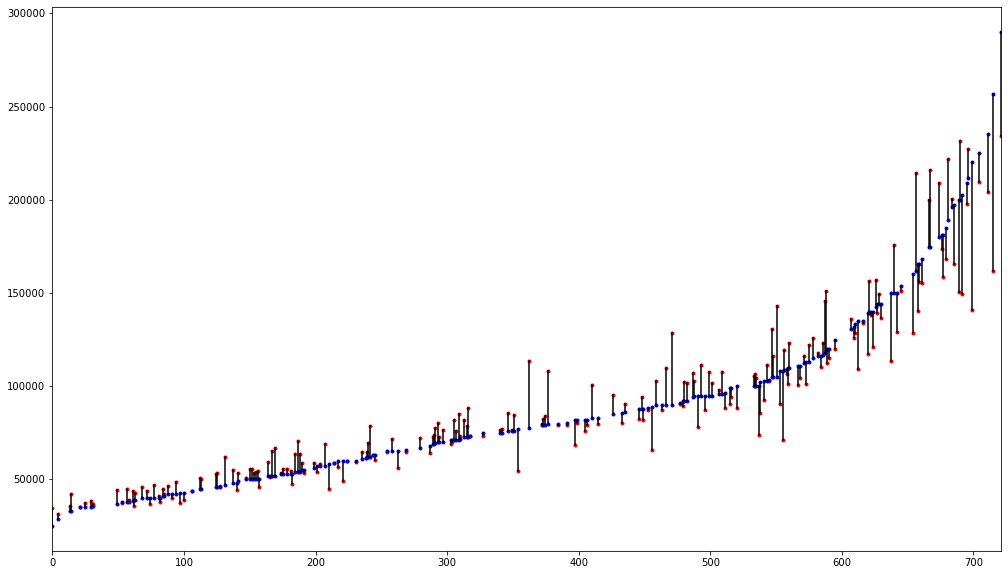

In [1485]:
plt.figure(figsize = (17, 10))
res.Predict.plot(style = 'r.')
res.Price.plot(style = 'b.')
for i in range(len(res.index)):
    plt.plot(np.repeat(res.index[i], 2), res.values[i], 'k')

In [2069]:
pd.concat([X_train, y_train], axis = 1).to_csv('train.csv', index = True)

In [2070]:
pd.concat([X_test, y_test], axis = 1).to_csv('test.csv', index = True)